# Test to Ensure GPU Functional and Available

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
from  IPython import display
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn import datasets
import pandas as pd
import numpy as np
import datetime
import os
from matplotlib import pyplot as plt
import pathlib
import shutil
import tempfile
from IPython.display import Image
import time
print(tf.__version__)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

2.1.0


__DD:__ Check to see if CUDA GPU is available:

In [2]:
tf.test.is_gpu_available(
    cuda_only=True, min_cuda_compute_capability=None
)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

__DD:__ Try new function based on warnings:

In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


__DD:__ I was wondering how to make sure GPU does the processing rather than CPU. I found the following excerpt from Tensorflow documentation:  

_"If a TensorFlow operation has both CPU and GPU implementations, by default the GPU devices will be given priority when the operation is assigned to a device. For example, tf.matmul has both CPU and GPU kernels. On a system with devices CPU:0 and GPU:0, the GPU:0 device will be selected to run tf.matmul unless you explicitly request running it on another device."_  

## Case Study 12

__DD:__ To get the tensorflow docs packages working I had to clone the github repository to my local file system and run:  
_pip install -q C:\Users\danie\Documents\GitHub\docs_

In [5]:
#get data
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz')
FEATURES = 28
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


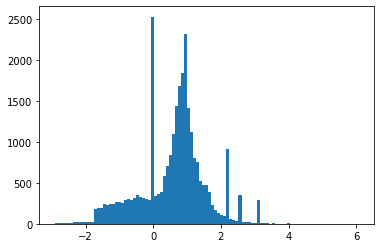

In [6]:
for features,label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins = 101)

__DD:__ This is where we will tweek to mimic the article

In [7]:
#"parameters were chosen using a subset of the HIGGS data 
#consisting of 2.6 million training examples and 100,000
#validation examples."

N_VALIDATION = int(100000)
N_TRAIN = int(2500000)
BUFFER_SIZE = int(2500000)
BATCH_SIZE = 1000
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [8]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

__DD:__ Original study's code has ".MLP"; which indicates they are using a multilayer perceptron as per pylearn documentation.  

According to Tensorflow documentation Sequential() is the equivalent to a multilayer perceptron.  

_"To build a simple, fully-connected network (i.e. multi-layer perceptron): model = tf.keras.Sequential()"_

__DD:__ Excerpts from the paper:

In [9]:
#"We selected a ﬁve-layer neural network with 300 hidden units
#in each layer, a learning rate of 0.05, and a weight decay 
#coeﬃcient of 1×10−5. 

#"Hidden units all used the tanh activation function."

#Weights were initialized from a normal distribution with
#zero mean and standard deviation 0.1 in the ﬁrst layer,
#0.001 in the output layer, and 0.05 all other hidden layers. 

#"Gradient computations were made on mini-batches of size 100.
#A momentum term increased linearly over the ﬁrst 200 epochs 
#from 0.9 to 0.99, at which point it remained constant."

#"The learning rate decayed by a factor of 1.0000002 every
#batch update until it reached a minimum of 10−6"

#"Training ended when the momentum had reached its maximum
#value and the minimum error on the validation set (500,000
#examples) had not decreased by more than a factor of 
#0.00001 over 10 epochs. This early stopping prevented 
#overﬁtting and resulted in each neural network being trained
#for 200-1000 epochs."

# 'Computations were performed using machines with 16 Intel Xeon
# 'cores, an NVIDIA Tesla C2070 graphics processor, and 64 GB 
# 'memory. All neural networks were trained using the GPU-accelerated
# 'Theano and Pylearn2 software libraries [24, 25]. Our code is 
# 'available at https://github.com/uci-igb/higgs-susy.

__DD:__ For reference: [higgs/analysis/template.py](higgs/analysis/template.py) is code from the Github described in the article. I used it to verify some of the parameters.

The article explains that they used _"Weight Decay 10^-5"_ which is equivalent to L2 regularization in tensorflow hence we have __kernel_regularizer=regularizers.l2(0.00001))__ in our code.

_L2 regularization is also called weight decay in the context of neural networks_

__DD__ We set __patience=10__ in call backs to mirror the original i.e. _"minimum error on the validation set (500,000 #examples) had not decreased by more than a factor of #0.00001 over 10 epochs"_

In [10]:
reproduced_model = tf.keras.Sequential([
    layers.Dense(300, activation='tanh',
                 kernel_regularizer=regularizers.l2(0.00001),
                 input_shape=(FEATURES,)),
    layers.Dense(300, activation='tanh'),
    layers.Dense(300, activation='tanh'),
    layers.Dense(300, activation='tanh'),
   # layers.Dense(300, activation='tanh'),
   # Using 5 layers gave us 370,201 parameters. 
   # I suspect that the paper is counting the input layer therefore they actually only used 4 so we only use 4
    layers.Dense(1)
])

callback = tf.keras.callbacks.EarlyStopping(monitor='binary_crossentropy', patience=10)

reproduced_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.05), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.losses.BinaryCrossentropy(from_logits=True,name='binary_crossentropy'),
                  'accuracy'], run_eagerly=False)



__DD:__ Using 5 layers gave us 370,201 parameters.  
__I suspect that the paper is counting the input layer therefore they actually only used 4.__

_The largest shallow network had 300,001 parameters, slightly more than the 279,901 parameters in the largest deep network_

Setting us up with 4 layers yields 279,901 parameters. Here is our reproduced the model; as best we can given the information available in the paper and the time that we have:

In [11]:
reproduced_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               8700      
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_2 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_3 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 301       
Total params: 279,901
Trainable params: 279,901
Non-trainable params: 0
_________________________________________________________________


In [12]:
%%time
reproduced_model.fit(train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=10000,
    callbacks=[callback],
    validation_data=validate_ds,
    verbose=0)

Wall time: 5min 37s


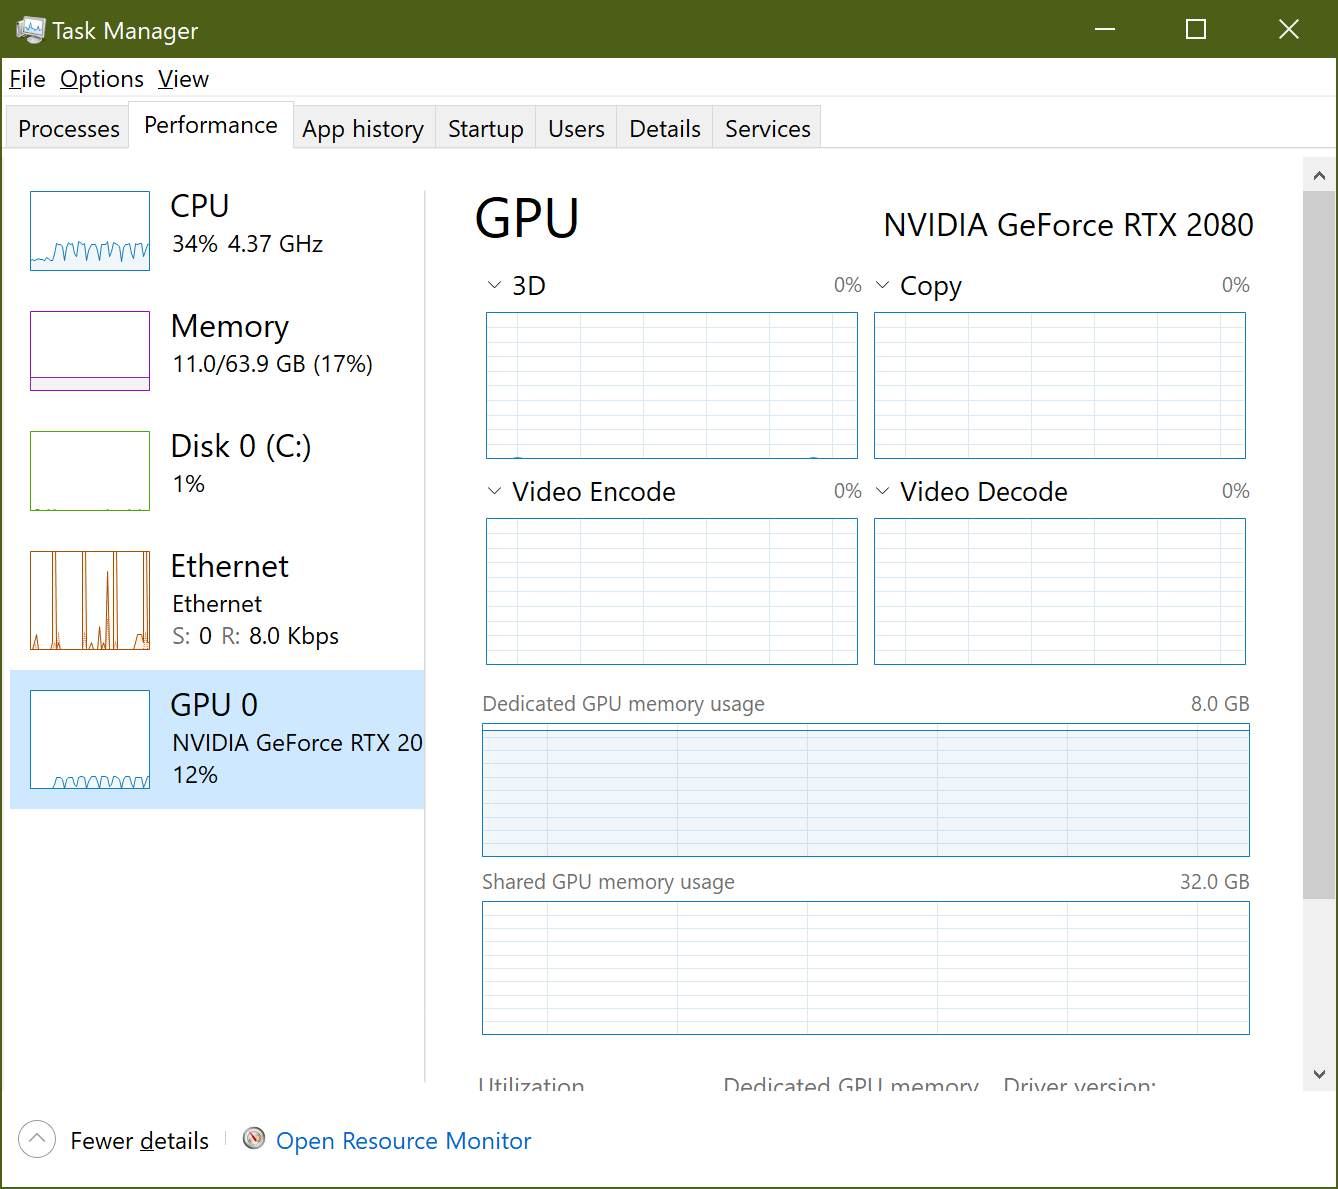

In [13]:
Image("GPU_Activity.png")

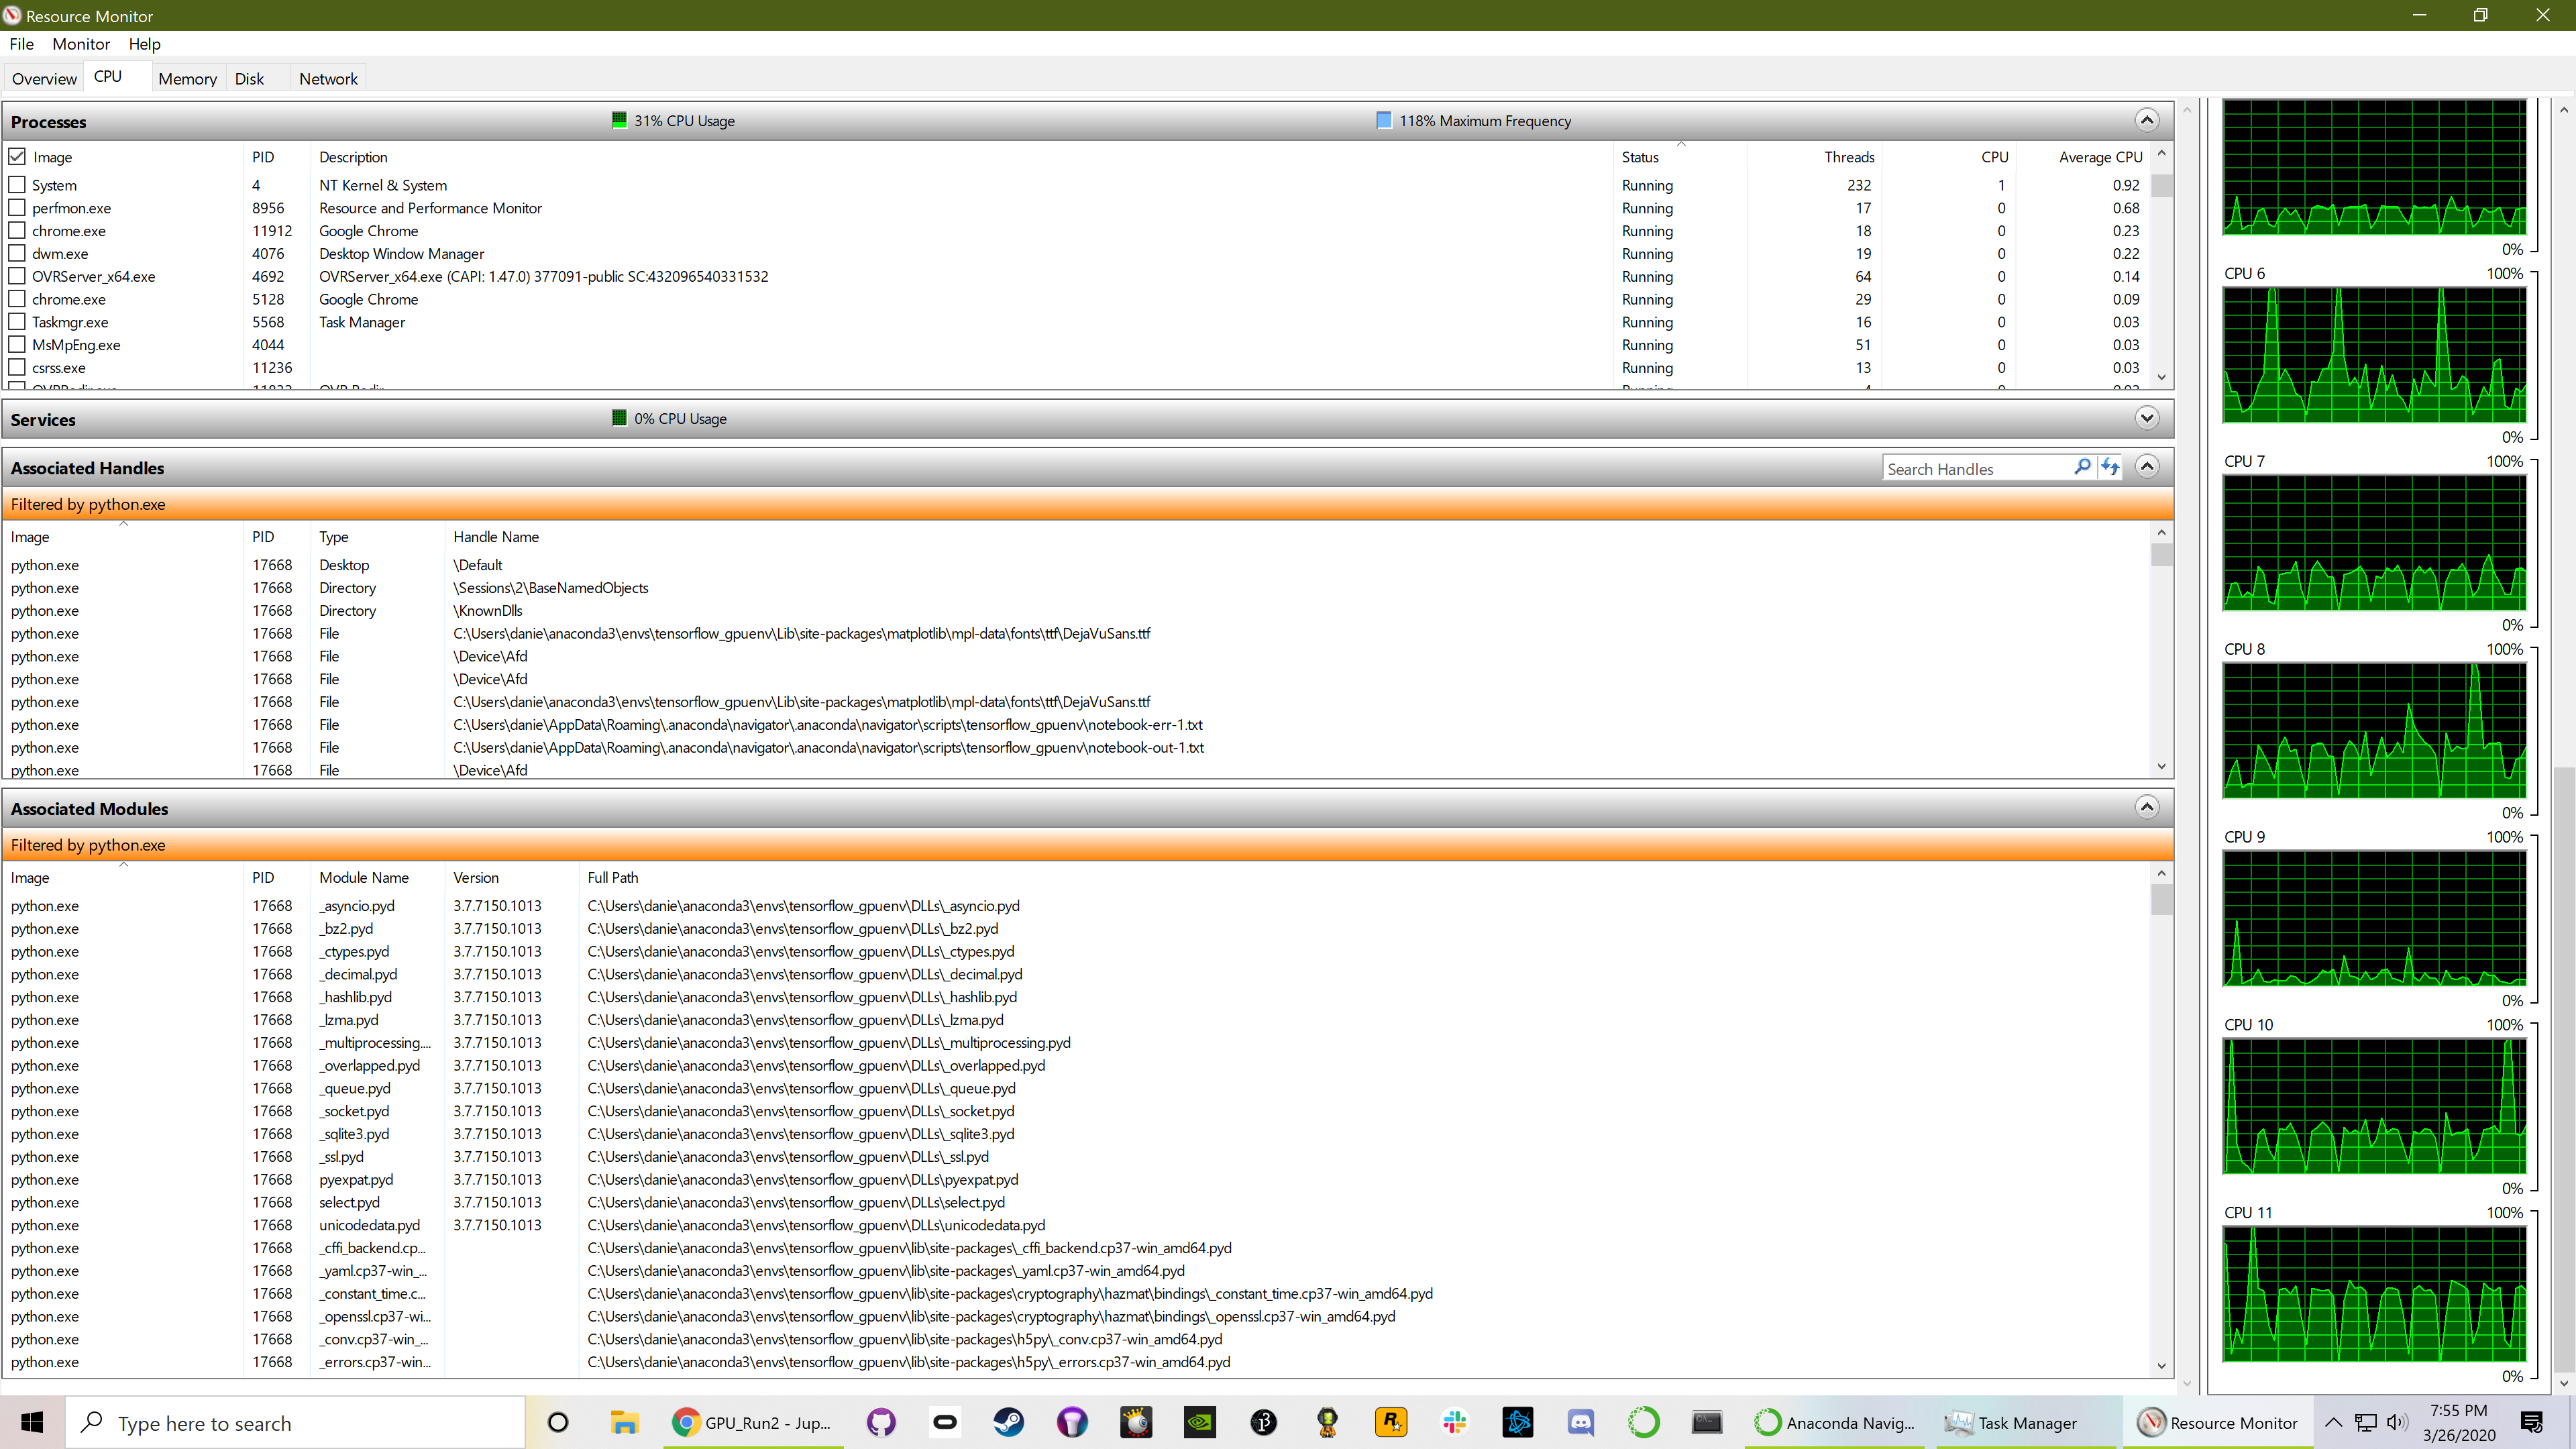

In [14]:
Image("CPU_Activity.png")

__DD__: Here are our results;

In [15]:
reproduced_model.evaluate(validate_ds)

    100/Unknown - 0s 3ms/step - loss: 0.6922 - binary_crossentropy: 0.6922 - accuracy: 0.4717

[0.6921752780675888, 0.69217515, 0.47166]

__DD:__ Model took approximately 3 minutes to run. Results are terrible in comparison to the original study. This is likely due to:  

- We did notexplicitly replicate the weights used in the originial study
- We are using tensorflow 2.1.0, the original used Theano and Pylearn2.

In [16]:
# result=reproduced_model(features)
# regularization_loss=tf.add_n(reproduced_model.losses)

__DD:__ Given functional more powerful hardware than was available in 2014 we could attempt a gridsearch to determine number of layers.  
Here is excerpt of code that uses a grid search from https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/ 

Original paper's hardware specs:

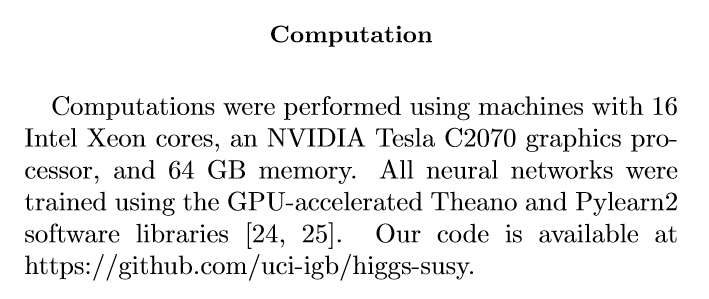

In [17]:
Image("OriginalHardware.PNG")

Our hardware specs:

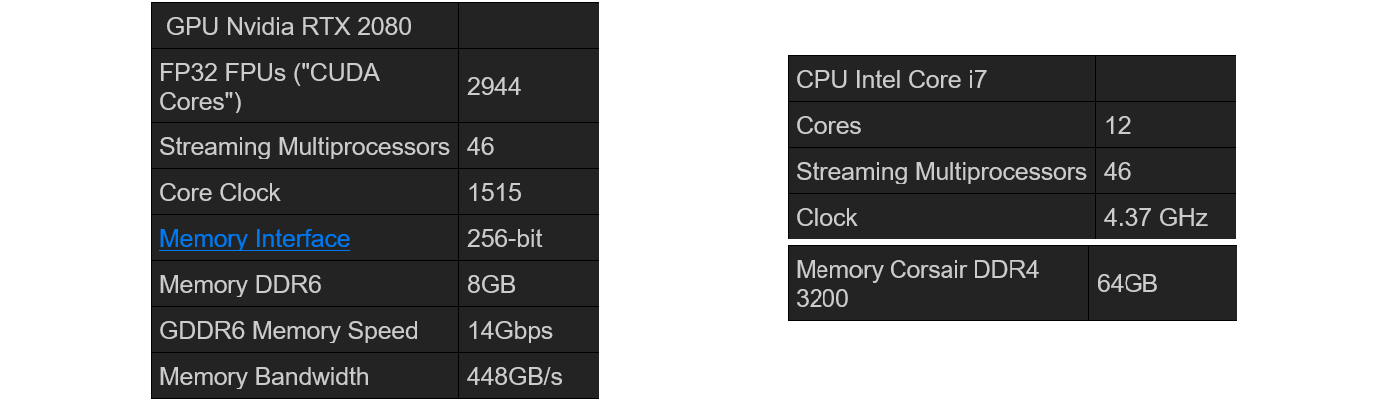

In [18]:
Image("OurHardware.PNG")

__DD:__ Try adjusting parameters based on tutorial:

In [19]:
adjusted_model_shallow = tf.keras.Sequential([
    layers.Dense(300, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    layers.Dropout(0.1),
    layers.Dense(1)
])

callback = tf.keras.callbacks.EarlyStopping(monitor='binary_crossentropy', patience=10)

adjusted_model_shallow.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.05), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.losses.BinaryCrossentropy(from_logits=True,name='binary_crossentropy'),
                  'accuracy'], run_eagerly=False)

adjusted_model_shallow.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 300)               8700      
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 301       
Total params: 9,001
Trainable params: 9,001
Non-trainable params: 0
_________________________________________________________________


In [20]:
%%time
adjusted_model_shallow.fit(train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=10000,
    callbacks=[callback],
    validation_data=validate_ds,
    verbose=0)

Wall time: 1min 24s


__DD__: With only 1 layer we have significant improvement  but still only 70% accurate:

In [21]:
adjusted_model_shallow.evaluate(validate_ds)

    100/Unknown - 0s 2ms/step - loss: 0.6458 - binary_crossentropy: 0.6326 - accuracy: 0.6190- 0s 2ms/step - loss: 0.6450 - binary_crossentro

[0.6458185237646102, 0.632566, 0.61898]

__DD__: Lets try same as above but deep with 5 layers:

In [31]:
adjusted_model_deep5 = tf.keras.Sequential([
    layers.Dense(300, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    layers.Dropout(0.1),
    layers.Dense(300, activation='elu'),
    layers.Dropout(0.1),
    layers.Dense(300, activation='elu'),
    layers.Dropout(0.1),
    layers.Dense(300, activation='elu'),
    layers.Dropout(0.1),
    layers.Dense(1)
])

callback = tf.keras.callbacks.EarlyStopping(monitor='binary_crossentropy', patience=10)

adjusted_model_deep5.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.05), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.losses.BinaryCrossentropy(from_logits=True,name='binary_crossentropy'),
                  'accuracy'], run_eagerly=False)


In [32]:
adjusted_model_deep5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 300)               8700      
_________________________________________________________________
dropout_9 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 300)               90300     
_________________________________________________________________
dropout_10 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 300)               90300     
_________________________________________________________________
dropout_11 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 300)              

In [33]:
%%time
adjusted_model_deep5.fit(train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=10000,
    callbacks=[callback],
    validation_data=validate_ds,
    verbose=0)

Wall time: 2min 27s


In [25]:
adjusted_model_deep5.evaluate(validate_ds)

    100/Unknown - 0s 3ms/step - loss: 0.6928 - binary_crossentropy: 0.6928 - accuracy: 0.4717

[0.6928279930353165, 0.69282806, 0.47166]

__DD__: Lets try same as above but with stopping having more patience: __patience=1000__

In [26]:
adjusted_model_deep5_patience1000 = tf.keras.Sequential([
    layers.Dense(300, activation='relu',
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    layers.Dropout(0.1),
    layers.Dense(300, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(300, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(300, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(1)
])

callback = tf.keras.callbacks.EarlyStopping(monitor='binary_crossentropy', patience=1000)

adjusted_model_deep5_patience1000.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.05), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.losses.BinaryCrossentropy(from_logits=True,name='binary_crossentropy'),
                  'accuracy'], run_eagerly=False)

In [27]:
adjusted_model_deep5_patience1000.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 300)               8700      
_________________________________________________________________
dropout_5 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 300)               90300     
_________________________________________________________________
dropout_6 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 300)               90300     
_________________________________________________________________
dropout_7 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 300)              

In [28]:
%%time
adjusted_model_deep5_patience1000.fit(train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=10000,
    callbacks=[callback],
    validation_data=validate_ds,
    verbose=0)

Wall time: 2h 2min 39s


In [29]:
adjusted_model_deep5_patience1000.evaluate(validate_ds)

    100/Unknown - 0s 3ms/step - loss: 0.6916 - binary_crossentropy: 0.6916 - accuracy: 0.4717

[0.6915599060058594, 0.69156, 0.47166]

In [ ]:
adjusted_model_deep1_patience1000_elu = tf.keras.Sequential([
    layers.Dense(300, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    layers.Dropout(0.1),
    layers.Dense(300, activation='relu'),
    layers.Dense(1)
])

callback = tf.keras.callbacks.EarlyStopping(monitor='binary_crossentropy', patience=1000)

adjusted_model_deep1_patience1000_elu.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.05), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.losses.BinaryCrossentropy(from_logits=True,name='binary_crossentropy'),
                  'accuracy'], run_eagerly=False)

In [ ]:
%%time
adjusted_model_deep1_patience1000_elu.fit(train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=10000,
    callbacks=[callback],
    validation_data=validate_ds,
    verbose=0)

In [ ]:
adjusted_model_deep1_patience1000_elu.evaluate(validate_ds)

In [30]:
# # Use scikit-learn to grid search the batch size and epochs
# import numpy
# from sklearn.model_selection import GridSearchCV
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.wrappers.scikit_learn import KerasClassifier
# # Function to create model, required for KerasClassifier
# def create_model():
# 	# create model
# 	model = Sequential()
# 	model.add(Dense(12, input_dim=8, activation='relu'))
# 	model.add(Dense(1, activation='sigmoid'))
# 	# Compile model
# 	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# 	return model
# # fix random seed for reproducibility
# seed = 7
# numpy.random.seed(seed)
# # load dataset
# dataset = numpy.loadtxt("pima-indians-diabetes.csv", delimiter=",")
# # split into input (X) and output (Y) variables
# X = dataset[:,0:8]
# Y = dataset[:,8]
# # create model
# model = KerasClassifier(build_fn=create_model, verbose=0)
# # define the grid search parameters
# batch_size = [10, 20, 40, 60, 80, 100]
# epochs = [10, 50, 100]
# param_grid = dict(batch_size=batch_size, epochs=epochs)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
# grid_result = grid.fit(X, Y)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))